In [1]:

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap 


from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap 
import lightgbm as lgb

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap 
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap 
import lightgbm as lgb
from xgboost import XGBRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder

/home/defuser/miniconda3/envs/moghis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# create new features by combining 2003 and 2012 scores and numbering ordinal variables
def feature_engineering(data):
    data['rjob_hrswk_change'] = (data['rjob_hrswk_12'] - data['rjob_hrswk_03']).astype(float)
    data['max_work_year']=data[['rjob_end_12','rjob_end_03']].max(axis=1).astype(float)
    data['years_since_work']=(data['year']-data['max_work_year']).astype(float)
    data['hincome_change']=(data['hincome_12']-data['hincome_03']).astype(float)
    data['niadl_change']=(data['n_iadl_12']-data['n_iadl_03']).astype(float)
    data['adl_change']=(data['n_adl_12']-data['n_adl_03']).astype(float)
    data['depr_change']=(data['n_depr_12']-data['n_depr_03']).astype(float)
    data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_change']=(data['glob_hlth_12']-data['glob_hlth_03']).astype(float)
    data['bmi_03']=data['bmi_03'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_12']=data['bmi_12'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_change']=(data['bmi_12']-data['bmi_03']).astype(float)
    data['employment_03']=data['employment_03'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['employment_12']=data['employment_12'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['memory_12']=data['memory_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['edu_gru_03']=data['edu_gru_03'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_12']=data['edu_gru_12'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_change']=(data['edu_gru_12']-data['edu_gru_03']).astype(float)
    data['illnesses_change']=(data['n_illnesses_12']-data['n_illnesses_03']).astype(float)
    return data

def get_cat_cols(data):
    # Get the columns with object datatype
    cat_columns=[]
    dummies=[]
    for col in data.columns:
        if data[col].dtype=='object' and 'uid' not in col:
            cat_columns.append(col)
            dummies.append(col)
        elif data[col].dtype!='object' and 'uid' not in col and (data[col].max()==1.0):
            cat_columns.append(col)
            data[col].fillna(0, inplace=True)
        else:
            continue
    return cat_columns, dummies

def encode_cat_cols(train_data, cat_cols, dummy_cols):
    enc = OneHotEncoder()
    enc.fit(train_data[dummy_cols])
    encoded_train_data=enc.transform(train_data[dummy_cols]).toarray()
    feature_names = enc.get_feature_names_out(dummy_cols)
    train_data.drop(columns=dummy_cols, inplace=True)
    encoded_train_df = pd.DataFrame(encoded_train_data, columns=feature_names)
    train_data[feature_names]=encoded_train_df[feature_names]
    return train_data, feature_names

In [3]:
#data
train=pd.read_csv("/home/data3/Ali/Code/Moghis/Dataset/train_features.csv")
y=pd.read_csv("/home/data3/Ali/Code/Moghis/Dataset/train_labels.csv")
test=pd.read_csv("/home/data3/Ali/Code/Moghis/Dataset/test_features.csv")
test_ground_truth=pd.read_csv("/home/data3/Ali/Code/Moghis/Dataset/sdoh_test_labels.csv")

#let merge train and label
main_df = pd.merge(train, y, on='uid', how='left')

#lets merged test AND sample submission
test_df = pd.merge(test, test_ground_truth, on='uid', how='left')

y=main_df['composite_score']
y_test=test_df['composite_score']
data=pd.concat((main_df,test_df)).reset_index(drop=True).copy()
data = feature_engineering(data)
data=data.drop(columns=['composite_score', 'uid'],axis=1)

# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    data[col] = pd.Categorical(data[col].fillna("Missing"))
    
#separate train and test
main_df=data[:len(main_df)]
test_df=data[len(main_df):]

/tmp/ipykernel_1768454/145228375.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_1768454/145228375.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_1768454/145228375.py:13: FutureWarning: Downcasting behavior in `

## Grouping Process

In [4]:
from sklearn.mixture import GaussianMixture

# X_Process = main_df
# y_process = y

X_Process = test_df
y_process = y_test

# Fit a Gaussian Mixture Model with 3 components
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(y_process.values.reshape(-1, 1))

# Extract the means and variances of the distributions
means = gmm.means_.flatten()
variances = gmm.covariances_.flatten()

# print("Means of the distributions:", means)
# print("Variances of the distributions:", variances)

# Predict the labels for the training data
gmm_labels = gmm.predict(y_process.values.reshape(-1, 1))

# Divide X_train and y_train into three groups based on GMM labels
group_0_X_train = X_Process[gmm_labels == 0]
group_0_y_train = y_process[gmm_labels == 0]

group_1_X_train = X_Process[gmm_labels == 1]
group_1_y_train = y_process[gmm_labels == 1]

group_2_X_train = X_Process[gmm_labels == 2]
group_2_y_train = y_process[gmm_labels == 2]

# Print the sizes of each group
print("Group 0 size:", group_0_X_train.shape[0])
print("Group 1 size:", group_1_X_train.shape[0])
print("Group 2 size:", group_2_X_train.shape[0])

# main_df = group_0_X_train
# y = group_0_y_train

test_df = group_2_X_train
y_test = group_2_y_train

Group 0 size: 369
Group 1 size: 284
Group 2 size: 452


In [5]:
# Calculate the mean of each group
mean_group_0 = group_0_y_train.mean()
mean_group_1 = group_1_y_train.mean()
mean_group_2 = group_2_y_train.mean()

print(f"Mean of Group 0: {mean_group_0}")
print(f"Mean of Group 1: {mean_group_1}")
print(f"Mean of Group 2: {mean_group_2}")

Mean of Group 0: 228.47425474254743
Mean of Group 1: 77.8169014084507
Mean of Group 2: 152.10398230088495


## LighGBoost ##

In [6]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(main_df, y, test_size=0.001, random_state=42)

# Best parameters for CatBoost
best_params = {
  'learning_rate': 0.07089438962267576,
  'num_leaves': 49,
  'max_depth': 4,
  'feature_fraction': 0.4839642718097913,
  'bagging_fraction': 0.5497799156909652,
  'lambda_l1': 0.058207015936292725,
  'lambda_l2': 0.08350139961819975,
  'min_child_samples': 85,
  'n_estimators': 4077,
  'objective': 'regression',
  'metric': 'rmse',
  'random_state': 42
}

model2 = lgb.train(
    params=best_params,
    train_set=lgb.Dataset(X_train, label=y_train, categorical_feature='auto'),
    valid_sets=lgb.Dataset(X_val, label=y_val, categorical_feature='auto'),
    num_boost_round=best_params['n_estimators'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=500, verbose=True),
    ]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2006
[LightGBM] [Info] Number of data points in the train set: 4338, number of used features: 193
[LightGBM] [Info] Start training from score 157.040341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

/home/defuser/miniconda3/envs/moghis/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


Mean Squared Error: 31.5345
R^2 Score: -1.0722


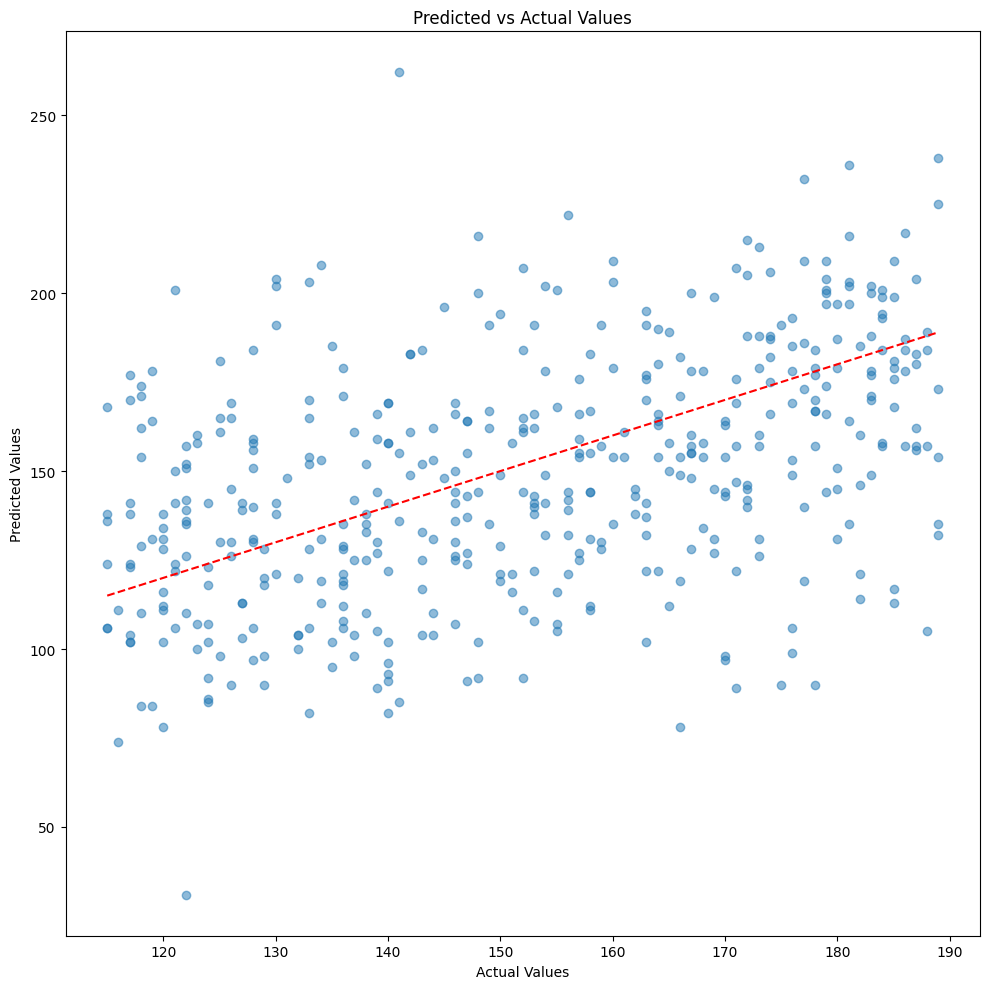

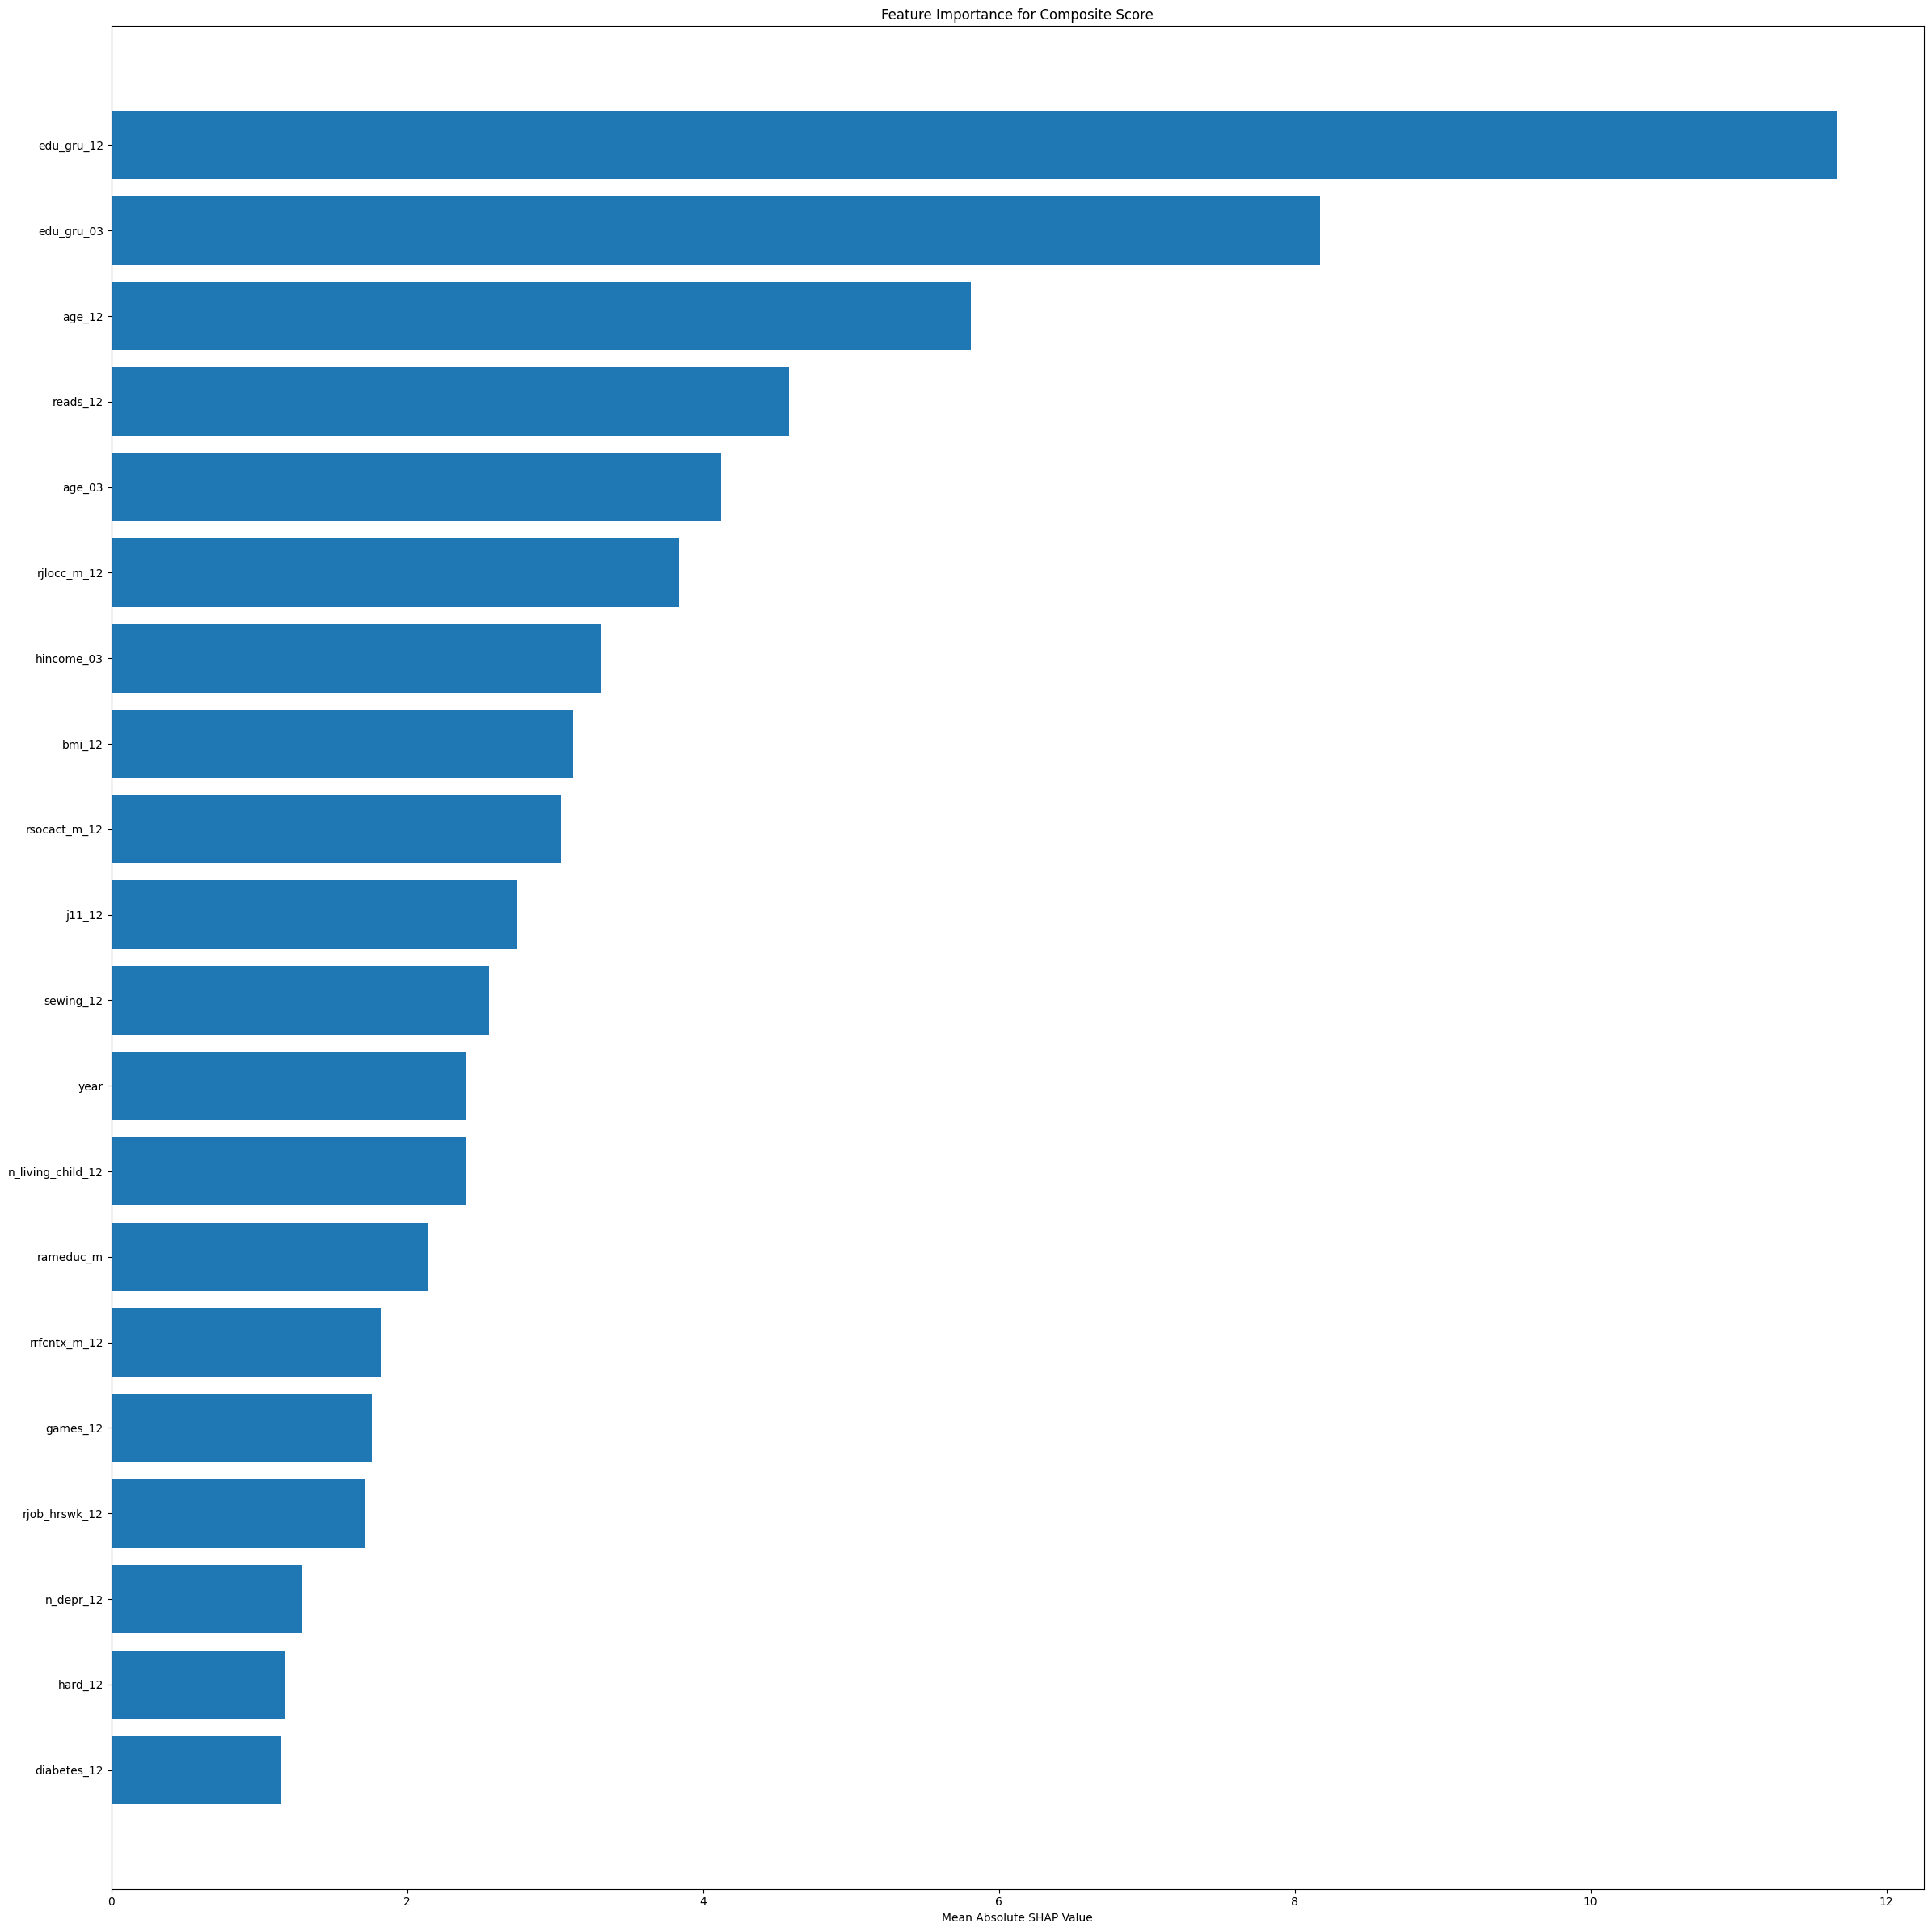

the top 20 features are:  ['edu_gru_12', 'edu_gru_03', 'age_12', 'reads_12', 'age_03', 'rjlocc_m_12', 'hincome_03', 'bmi_12', 'rsocact_m_12', 'j11_12', 'sewing_12', 'year', 'n_living_child_12', 'rameduc_m', 'rrfcntx_m_12', 'games_12', 'rjob_hrswk_12', 'n_depr_12', 'hard_12', 'diabetes_12']
the rank of rjob_hrswk_change is: 93 out of 195 features
the rank of max_work_year is: 64 out of 195 features
the rank of years_since_work is: 92 out of 195 features
the rank of hincome_change is: 49 out of 195 features
the rank of niadl_change is: 97 out of 195 features
the rank of adl_change is: 87 out of 195 features
the rank of depr_change is: 70 out of 195 features
the rank of glob_hlth_change is: 68 out of 195 features
the rank of bmi_change is: 24 out of 195 features
the rank of edu_gru_change is: 163 out of 195 features
the rank of illnesses_change is: 94 out of 195 features


In [7]:
# Make predictions
y_pred = model2.predict(test_df)
y_pred = np.round(y_pred).astype(int)

# Calculate metrics
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Plot predictions vs actual
def plot_predictions_vs_actual(y_test, y_pred):
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs Actual Values")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.tight_layout()
    # plt.savefig('/home/data3/Ali/Code/Moghis/results/LightBoost/predictions_vs_actual_composite_score.png', bbox_inches='tight')
    plt.show()

plot_predictions_vs_actual(y_test, y_pred)

explainer = shap.TreeExplainer(model2)
shap_values_lgb = explainer.shap_values(test_df)
feature_importance = pd.DataFrame({
    'Feature': main_df.columns.to_list(),
    'Mean_Absolute_SHAP': np.mean(np.abs(shap_values_lgb), axis=0)
})

feature_importance = feature_importance.sort_values(by='Mean_Absolute_SHAP', ascending=False).reset_index(drop=True)

# feature_importance.to_csv('/home/data3/Ali/Code/Moghis/results/LightBoost/feature_importance_composite_score.csv', index=False)
plt.figure(figsize=(24, 24))
plt.barh(feature_importance['Feature'][:20], feature_importance['Mean_Absolute_SHAP'][:20])
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance for Composite Score')
plt.tight_layout()
plt.show()
# plt.savefig('/home/data3/Ali/Code/Moghis/results/LightBoost/feature_importance_plot_composite_score.png', bbox_inches='tight')
plt.close()
print("the top 20 features are: ", feature_importance['Feature'][:20].to_list())

created_features = ["rjob_hrswk_change", "max_work_year", "years_since_work", "hincome_change", "niadl_change", "adl_change", "depr_change", "glob_hlth_change", "bmi_change", "edu_gru_change", "illnesses_change"]
for feature in created_features:
    print(f"the rank of {feature} is: {feature_importance[feature_importance['Feature'] == feature].index[0]} out of {len(feature_importance)} features")

## CatBoost ##

In [8]:
X_train, X_val, y_train, y_val = train_test_split(main_df, y, test_size=0.001, random_state=42)


# Best parameters for CatBoost
best_params = {
    'depth': 6,
    'learning_rate': 0.025804617832891515,
    'l2_leaf_reg': 0.22567510948252656,
    'random_strength': 1.8064759944089426,
    'bagging_temperature': 0.4675254776654324,
    'iterations': 1224
}

# Initialize and train CatBoostRegressor
# categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
model2 = CatBoostRegressor(
    **best_params,
    loss_function='RMSE',
    cat_features=main_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    verbose=100,
    early_stopping_rounds=500,
    random_state=42
)
model2.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	learn: 60.2328742	test: 70.2511139	best: 70.2511139 (0)	total: 62ms	remaining: 1m 15s
100:	learn: 41.3925974	test: 46.7546765	best: 46.7546765 (100)	total: 1.4s	remaining: 15.6s
200:	learn: 38.6240108	test: 40.1624675	best: 40.1624675 (200)	total: 2.72s	remaining: 13.8s
300:	learn: 37.1348037	test: 37.3507143	best: 37.3403904 (299)	total: 4.1s	remaining: 12.6s
400:	learn: 35.6643537	test: 36.6687054	best: 36.5536159 (398)	total: 5.48s	remaining: 11.2s
500:	learn: 34.1788256	test: 35.7284741	best: 35.2541153 (468)	total: 6.87s	remaining: 9.92s
600:	learn: 33.0934189	test: 35.5874344	best: 35.2541153 (468)	total: 8.26s	remaining: 8.57s
700:	learn: 32.0378928	test: 35.0526244	best: 34.9646090 (677)	total: 9.66s	remaining: 7.21s
800:	learn: 31.0457357	test: 35.5191549	best: 34.9508528 (706)	total: 11s	remaining: 5.83s
900:	learn: 30.1705533	test: 36.0567949	best: 34.9508528 (706)	total: 12.4s	remaining: 4.46s
1000:	learn: 29.3678066	test: 36.1936538	best: 34.9508528 (706)	total: 13.8s	r


Mean Squared Error: 30.6714
R^2 Score: -0.9604


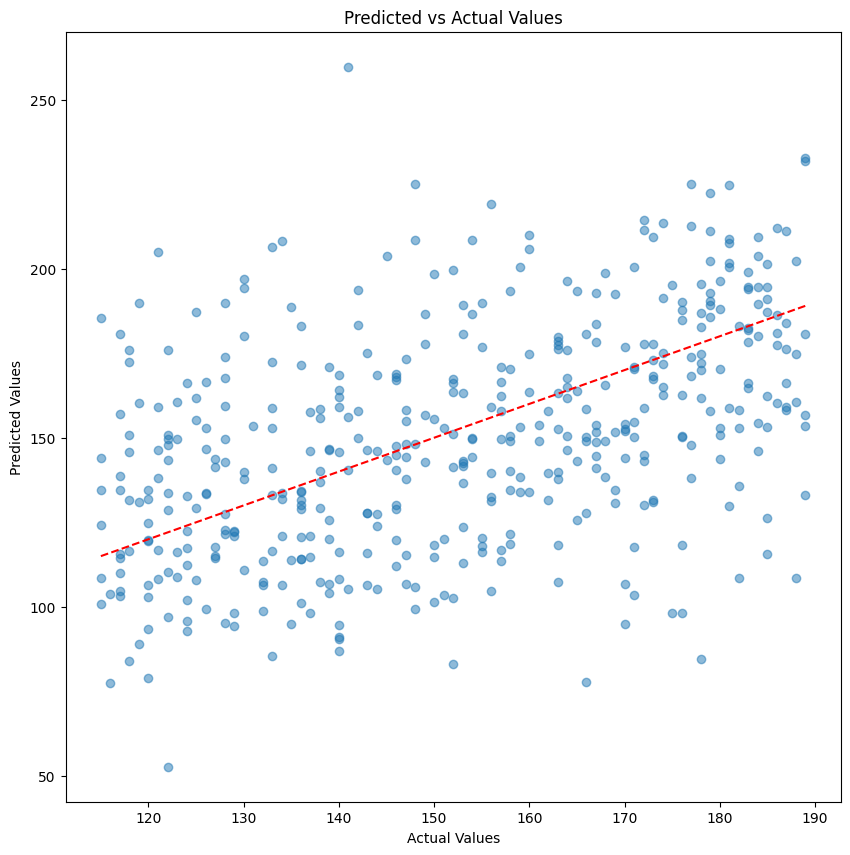

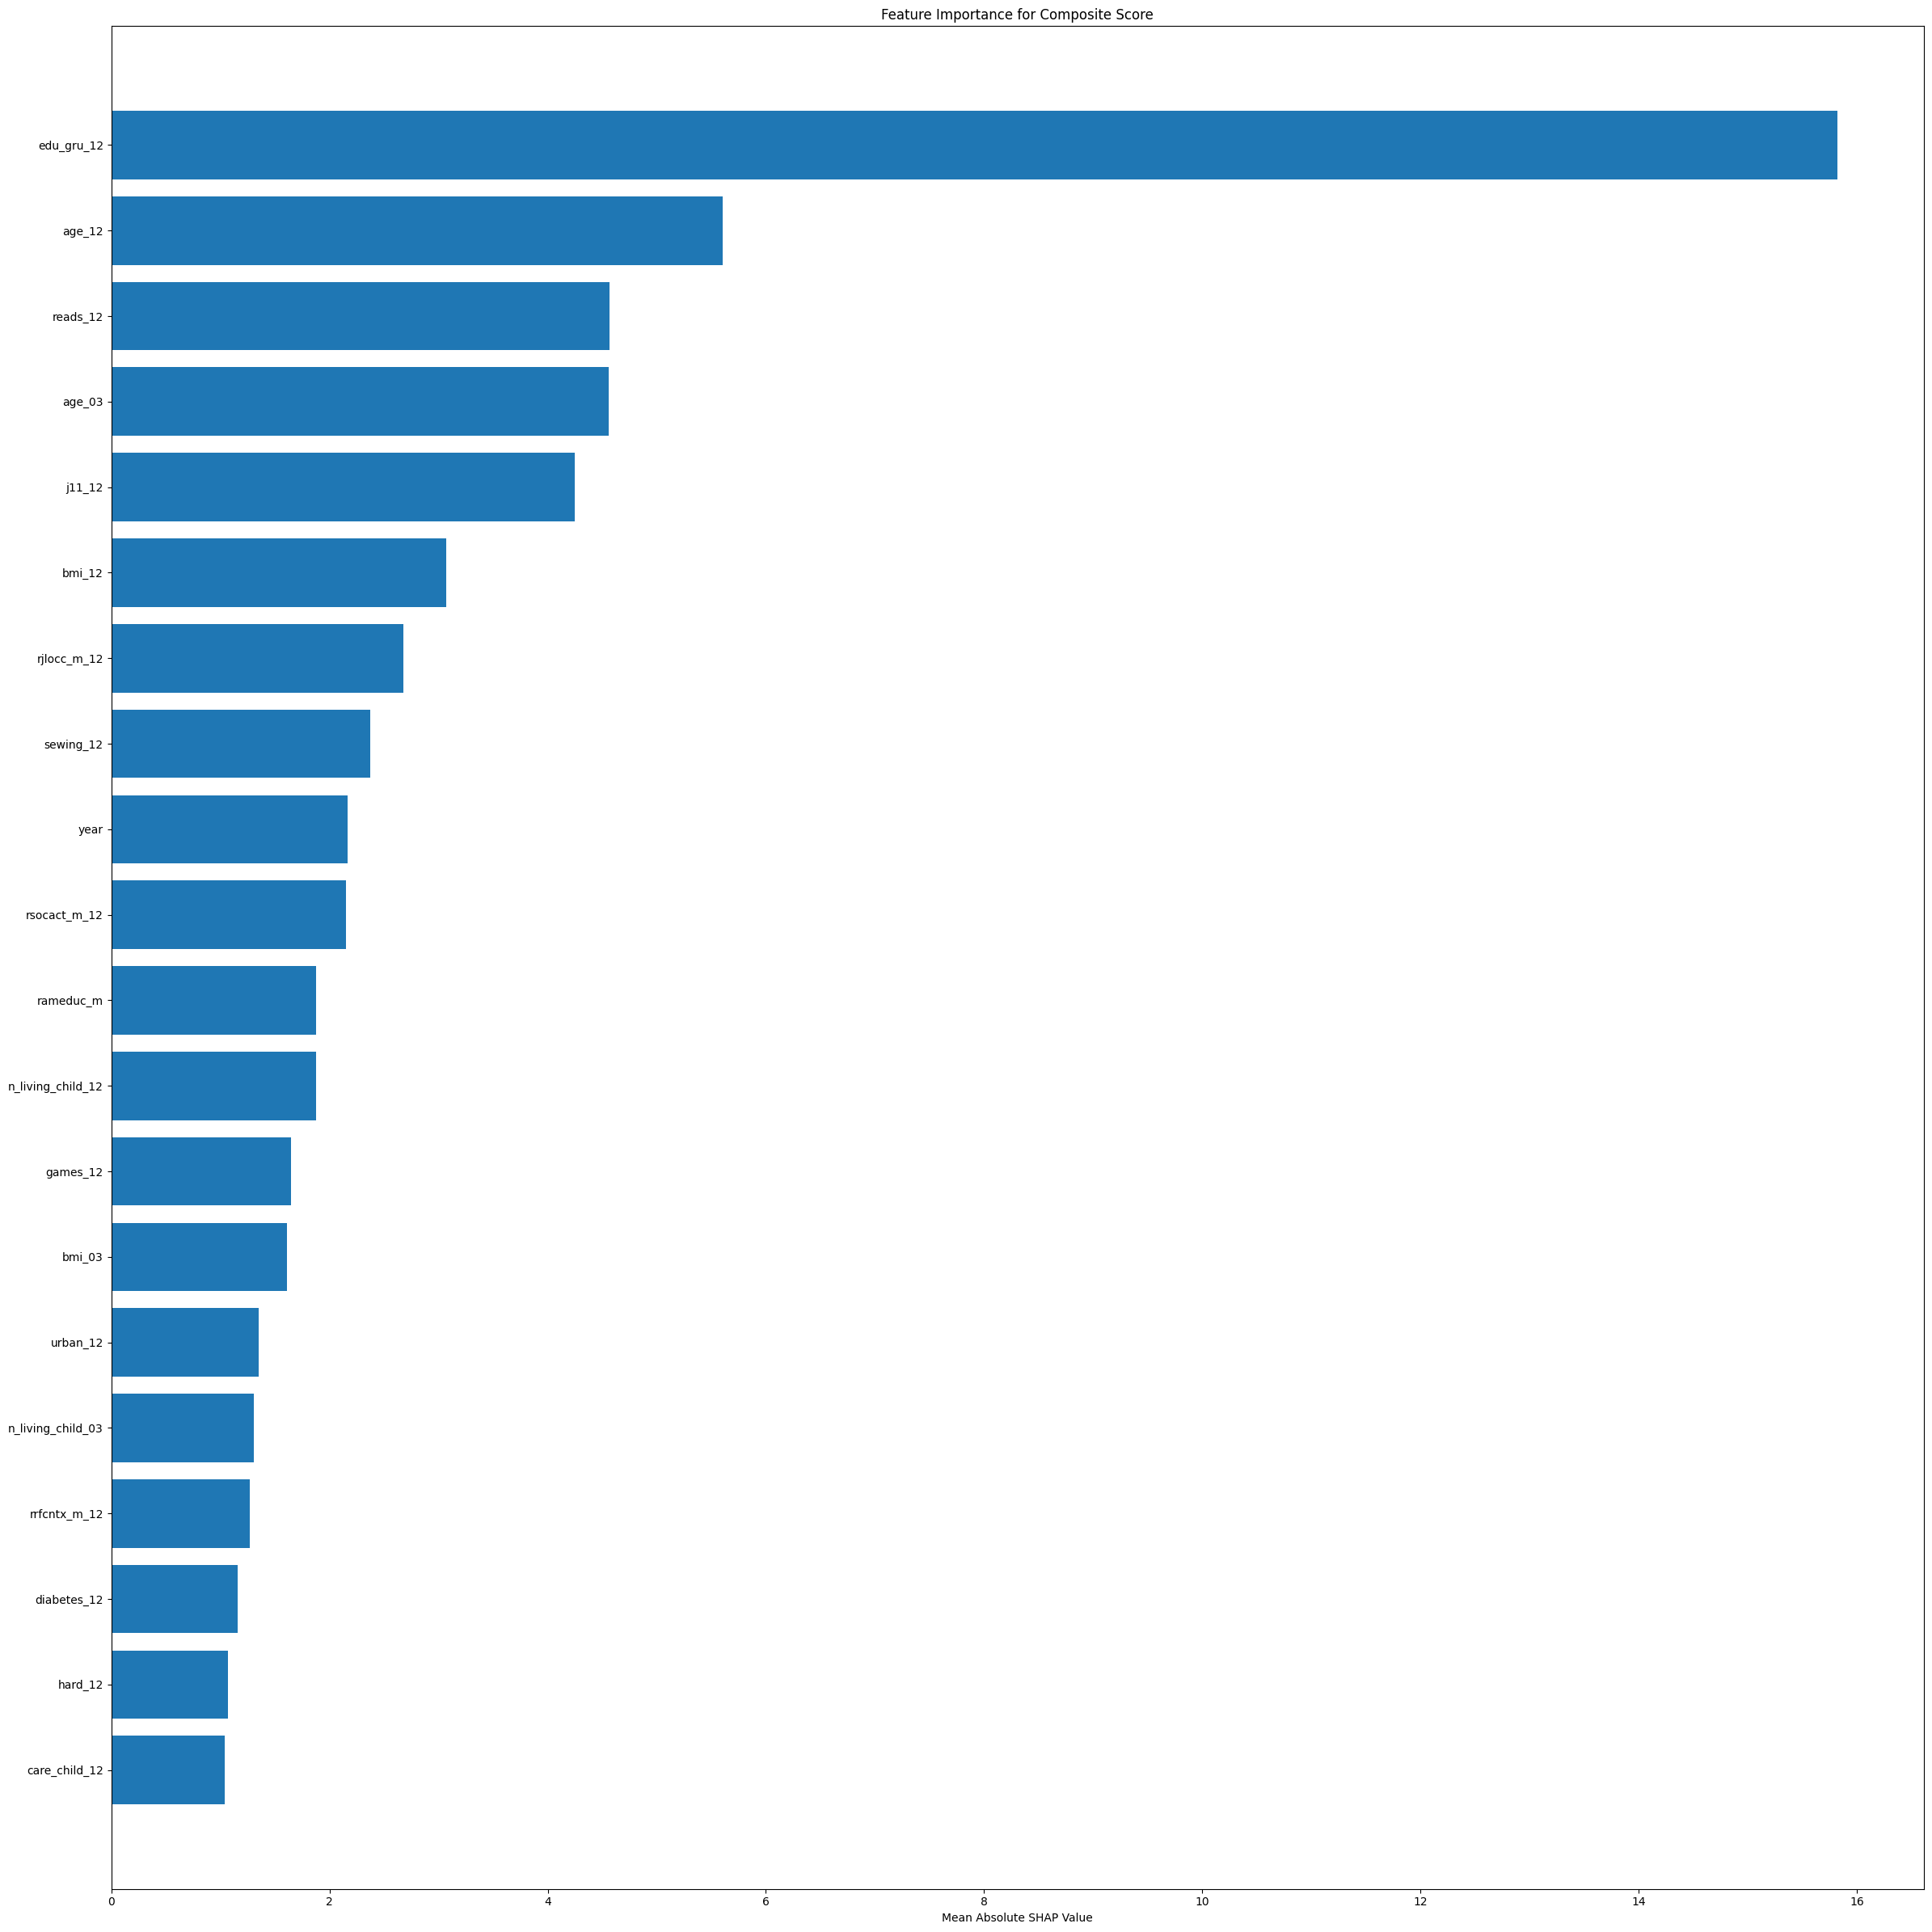

the top 20 features are:  ['edu_gru_12', 'age_12', 'reads_12', 'age_03', 'j11_12', 'bmi_12', 'rjlocc_m_12', 'sewing_12', 'year', 'rsocact_m_12', 'rameduc_m', 'n_living_child_12', 'games_12', 'bmi_03', 'urban_12', 'n_living_child_03', 'rrfcntx_m_12', 'diabetes_12', 'hard_12', 'care_child_12']
the rank of rjob_hrswk_change is: 153 out of 195 features
the rank of max_work_year is: 83 out of 195 features
the rank of years_since_work is: 89 out of 195 features
the rank of hincome_change is: 62 out of 195 features
the rank of niadl_change is: 146 out of 195 features
the rank of adl_change is: 70 out of 195 features
the rank of depr_change is: 67 out of 195 features
the rank of glob_hlth_change is: 127 out of 195 features
the rank of bmi_change is: 51 out of 195 features
the rank of edu_gru_change is: 26 out of 195 features
the rank of illnesses_change is: 172 out of 195 features


In [9]:

# Make predictions
y_pred = model2.predict(test_df)

# Calculate metrics
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Plot predictions vs actual
def plot_predictions_vs_actual(y_test, y_pred):
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs Actual Values")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.show()

plot_predictions_vs_actual(y_test, y_pred)
# plt.savefig('/home/data3/Ali/Code/Moghis/results/predictions_vs_actual_composite_score.png', bbox_inches='tight')

explainer = shap.TreeExplainer(model2)
shap_values_catboost = explainer.shap_values(test_df)
feature_importance = pd.DataFrame({
    'Feature': main_df.columns.to_list(),
    'Mean_Absolute_SHAP': np.mean(np.abs(shap_values_catboost), axis=0)
})
feature_importance = feature_importance.sort_values(by='Mean_Absolute_SHAP', ascending=False).reset_index(drop=True)

# feature_importance.to_csv('/home/data3/Ali/Code/Moghis/results/feature_importance_composite_score.csv', index=False)
plt.figure(figsize=(24, 24))
plt.barh(feature_importance['Feature'][:20], feature_importance['Mean_Absolute_SHAP'][:20])
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance for Composite Score')
plt.tight_layout()
plt.show()
# plt.savefig('/home/data3/Ali/Code/Moghis/results/feature_importance_plot_composite_score.png', bbox_inches='tight')
plt.close()

print("the top 20 features are: ", feature_importance['Feature'][:20].to_list())

created_features = ["rjob_hrswk_change", "max_work_year", "years_since_work", "hincome_change", "niadl_change", "adl_change", "depr_change", "glob_hlth_change", "bmi_change", "edu_gru_change", "illnesses_change"]
for feature in created_features:
    print(f"the rank of {feature} is: {feature_importance[feature_importance['Feature'] == feature].index[0]} out of {len(feature_importance)} features")

## XGBoost ##

In [10]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(main_df, y, test_size=0.001, random_state=42)

# Best parameters for XGBoost
best_params = {
  'learning_rate': 0.033763045458285304,
  'max_depth': 3,
  'min_child_weight': 14,
  'subsample': 0.9500263286639197,
  'colsample_bytree': 0.7747635615654157,
  'gamma': 7.558507636378349,
  'reg_alpha': 0.4378783168336932,
  'reg_lambda': 2.8408676886824322,
  'n_estimators': 2804
  }


model2 = XGBRegressor(**best_params, random_state=42, enable_categorical=True, early_stopping_rounds=500, eval_metric=root_mean_squared_error,)
model2.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

[0]	validation_0-rmse:70.07182	validation_0-root_mean_squared_error:70.07182
[1]	validation_0-rmse:69.23374	validation_0-root_mean_squared_error:69.23374
[2]	validation_0-rmse:68.45840	validation_0-root_mean_squared_error:68.45840
[3]	validation_0-rmse:67.58054	validation_0-root_mean_squared_error:67.58054
[4]	validation_0-rmse:66.75906	validation_0-root_mean_squared_error:66.75906
[5]	validation_0-rmse:66.06690	validation_0-root_mean_squared_error:66.06690
[6]	validation_0-rmse:65.32407	validation_0-root_mean_squared_error:65.32407
[7]	validation_0-rmse:64.73959	validation_0-root_mean_squared_error:64.73959
[8]	validation_0-rmse:64.16536	validation_0-root_mean_squared_error:64.16536
[9]	validation_0-rmse:63.64817	validation_0-root_mean_squared_error:63.64817
[10]	validation_0-rmse:62.84326	validation_0-root_mean_squared_error:62.84326
[11]	validation_0-rmse:62.38333	validation_0-root_mean_squared_error:62.38332
[12]	validation_0-rmse:61.80279	validation_0-root_mean_squared_error:61.80

/home/defuser/miniconda3/envs/moghis/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7747635615654157, device=None,
             early_stopping_rounds=500, enable_categorical=True,
             eval_metric=<function root_mean_squared_error at 0x7f588a018ee0>,
             feature_types=None, gamma=7.558507636378349, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.033763045458285304, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=14, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2804, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


Mean Squared Error: 31.9995
R^2 Score: -1.1338


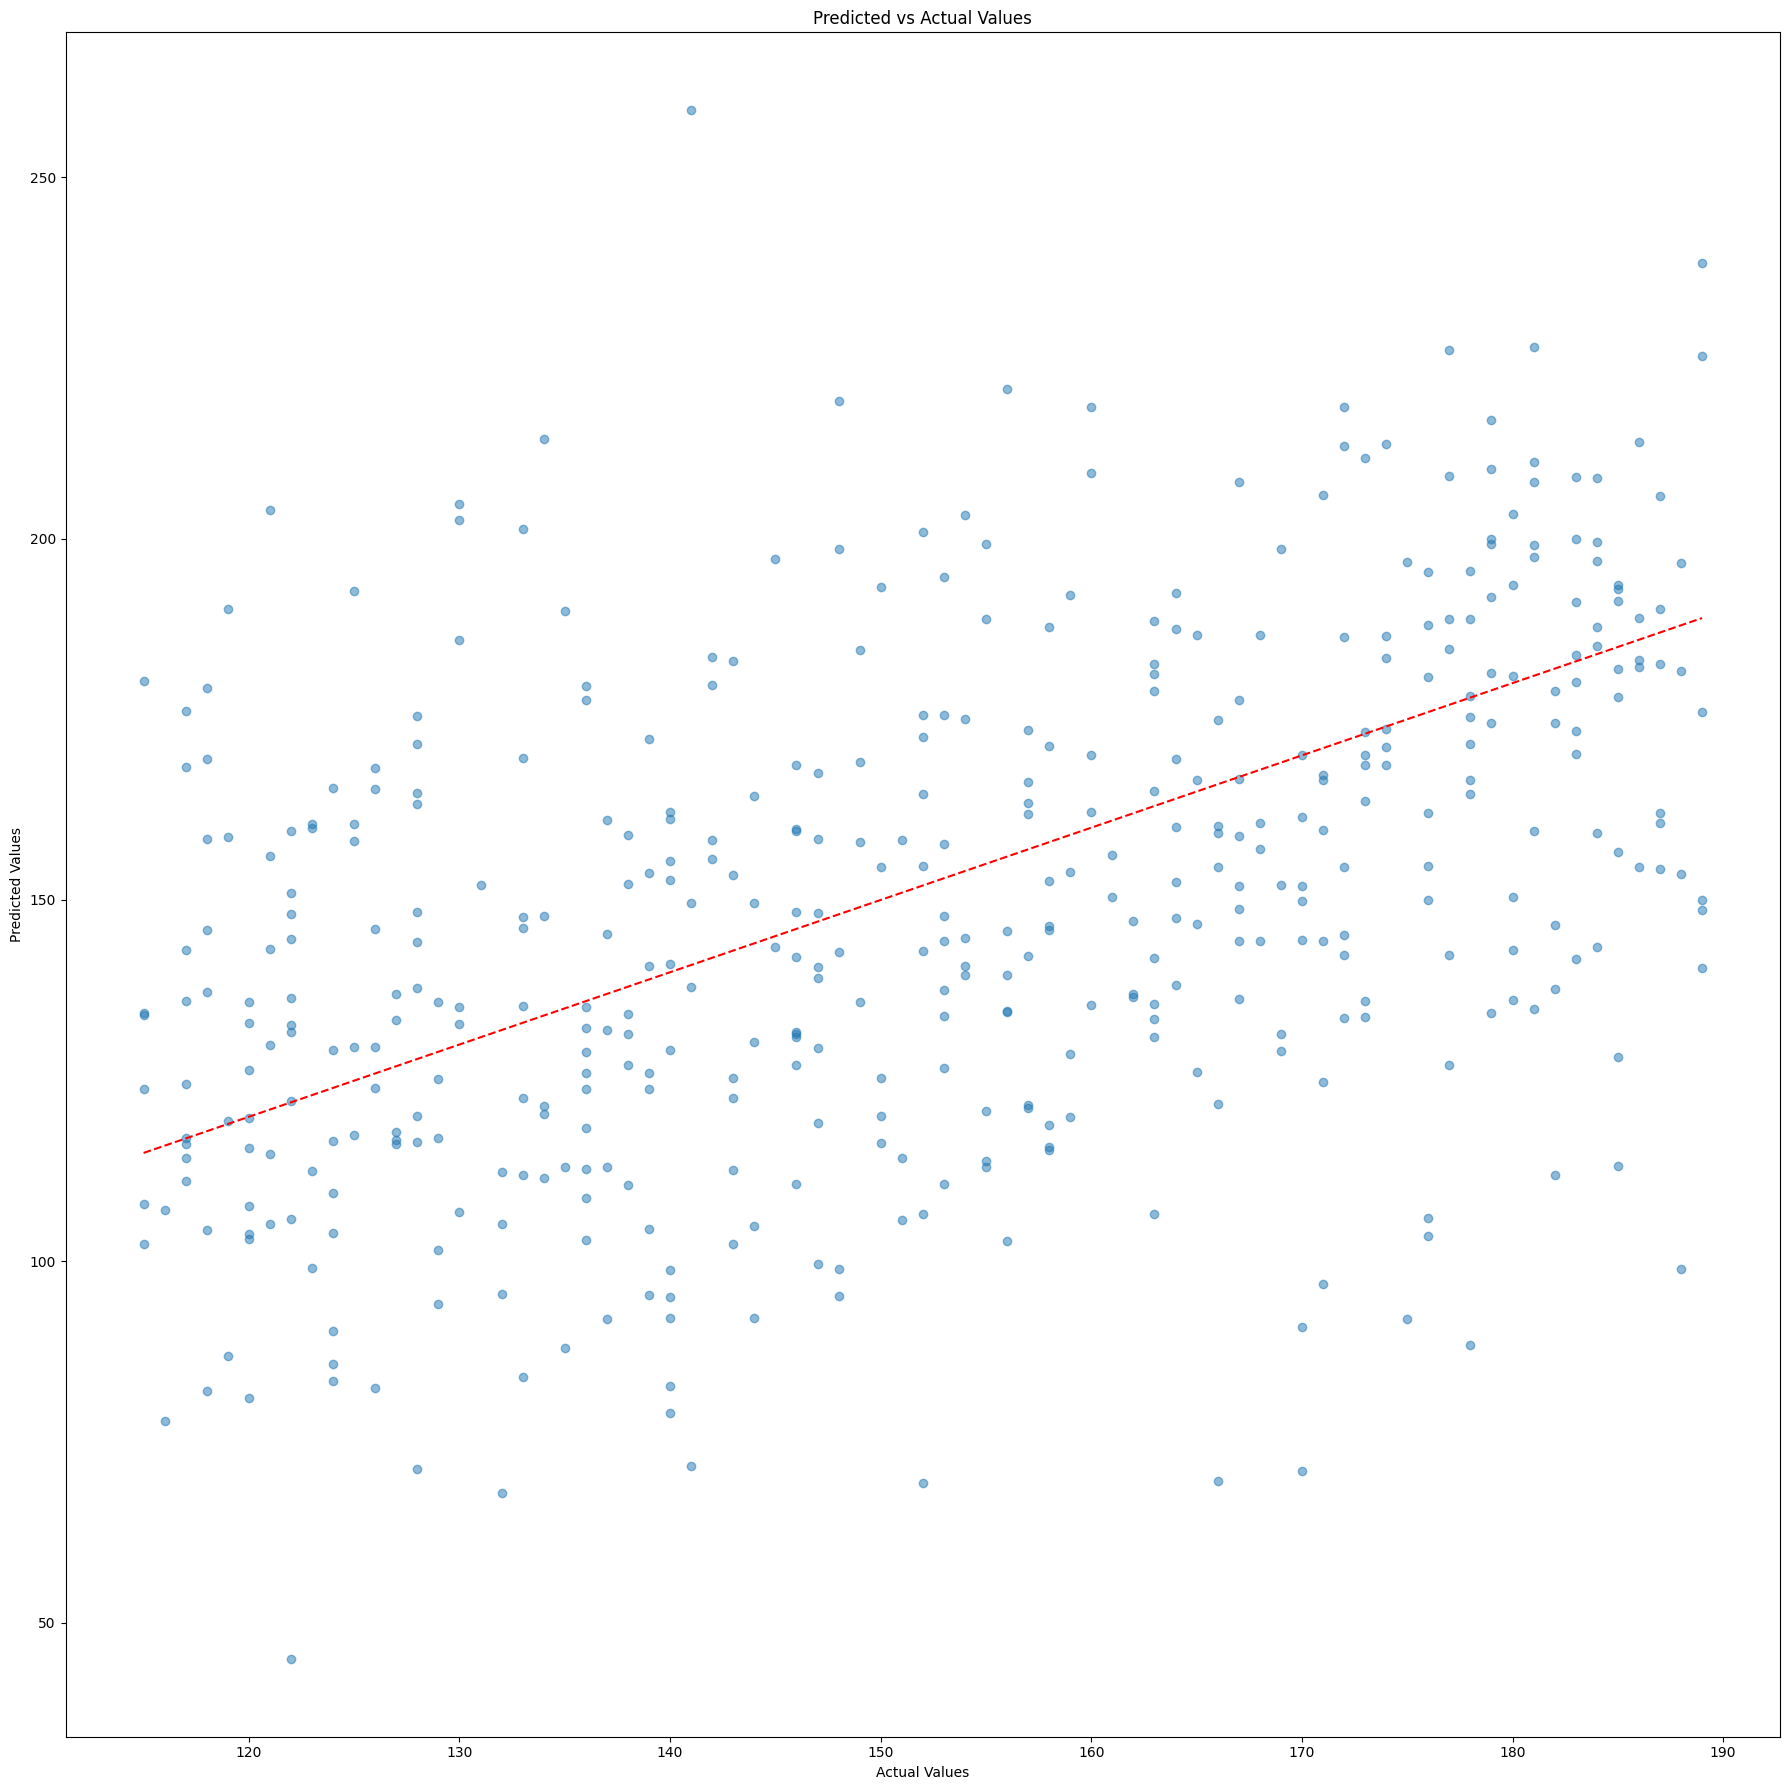

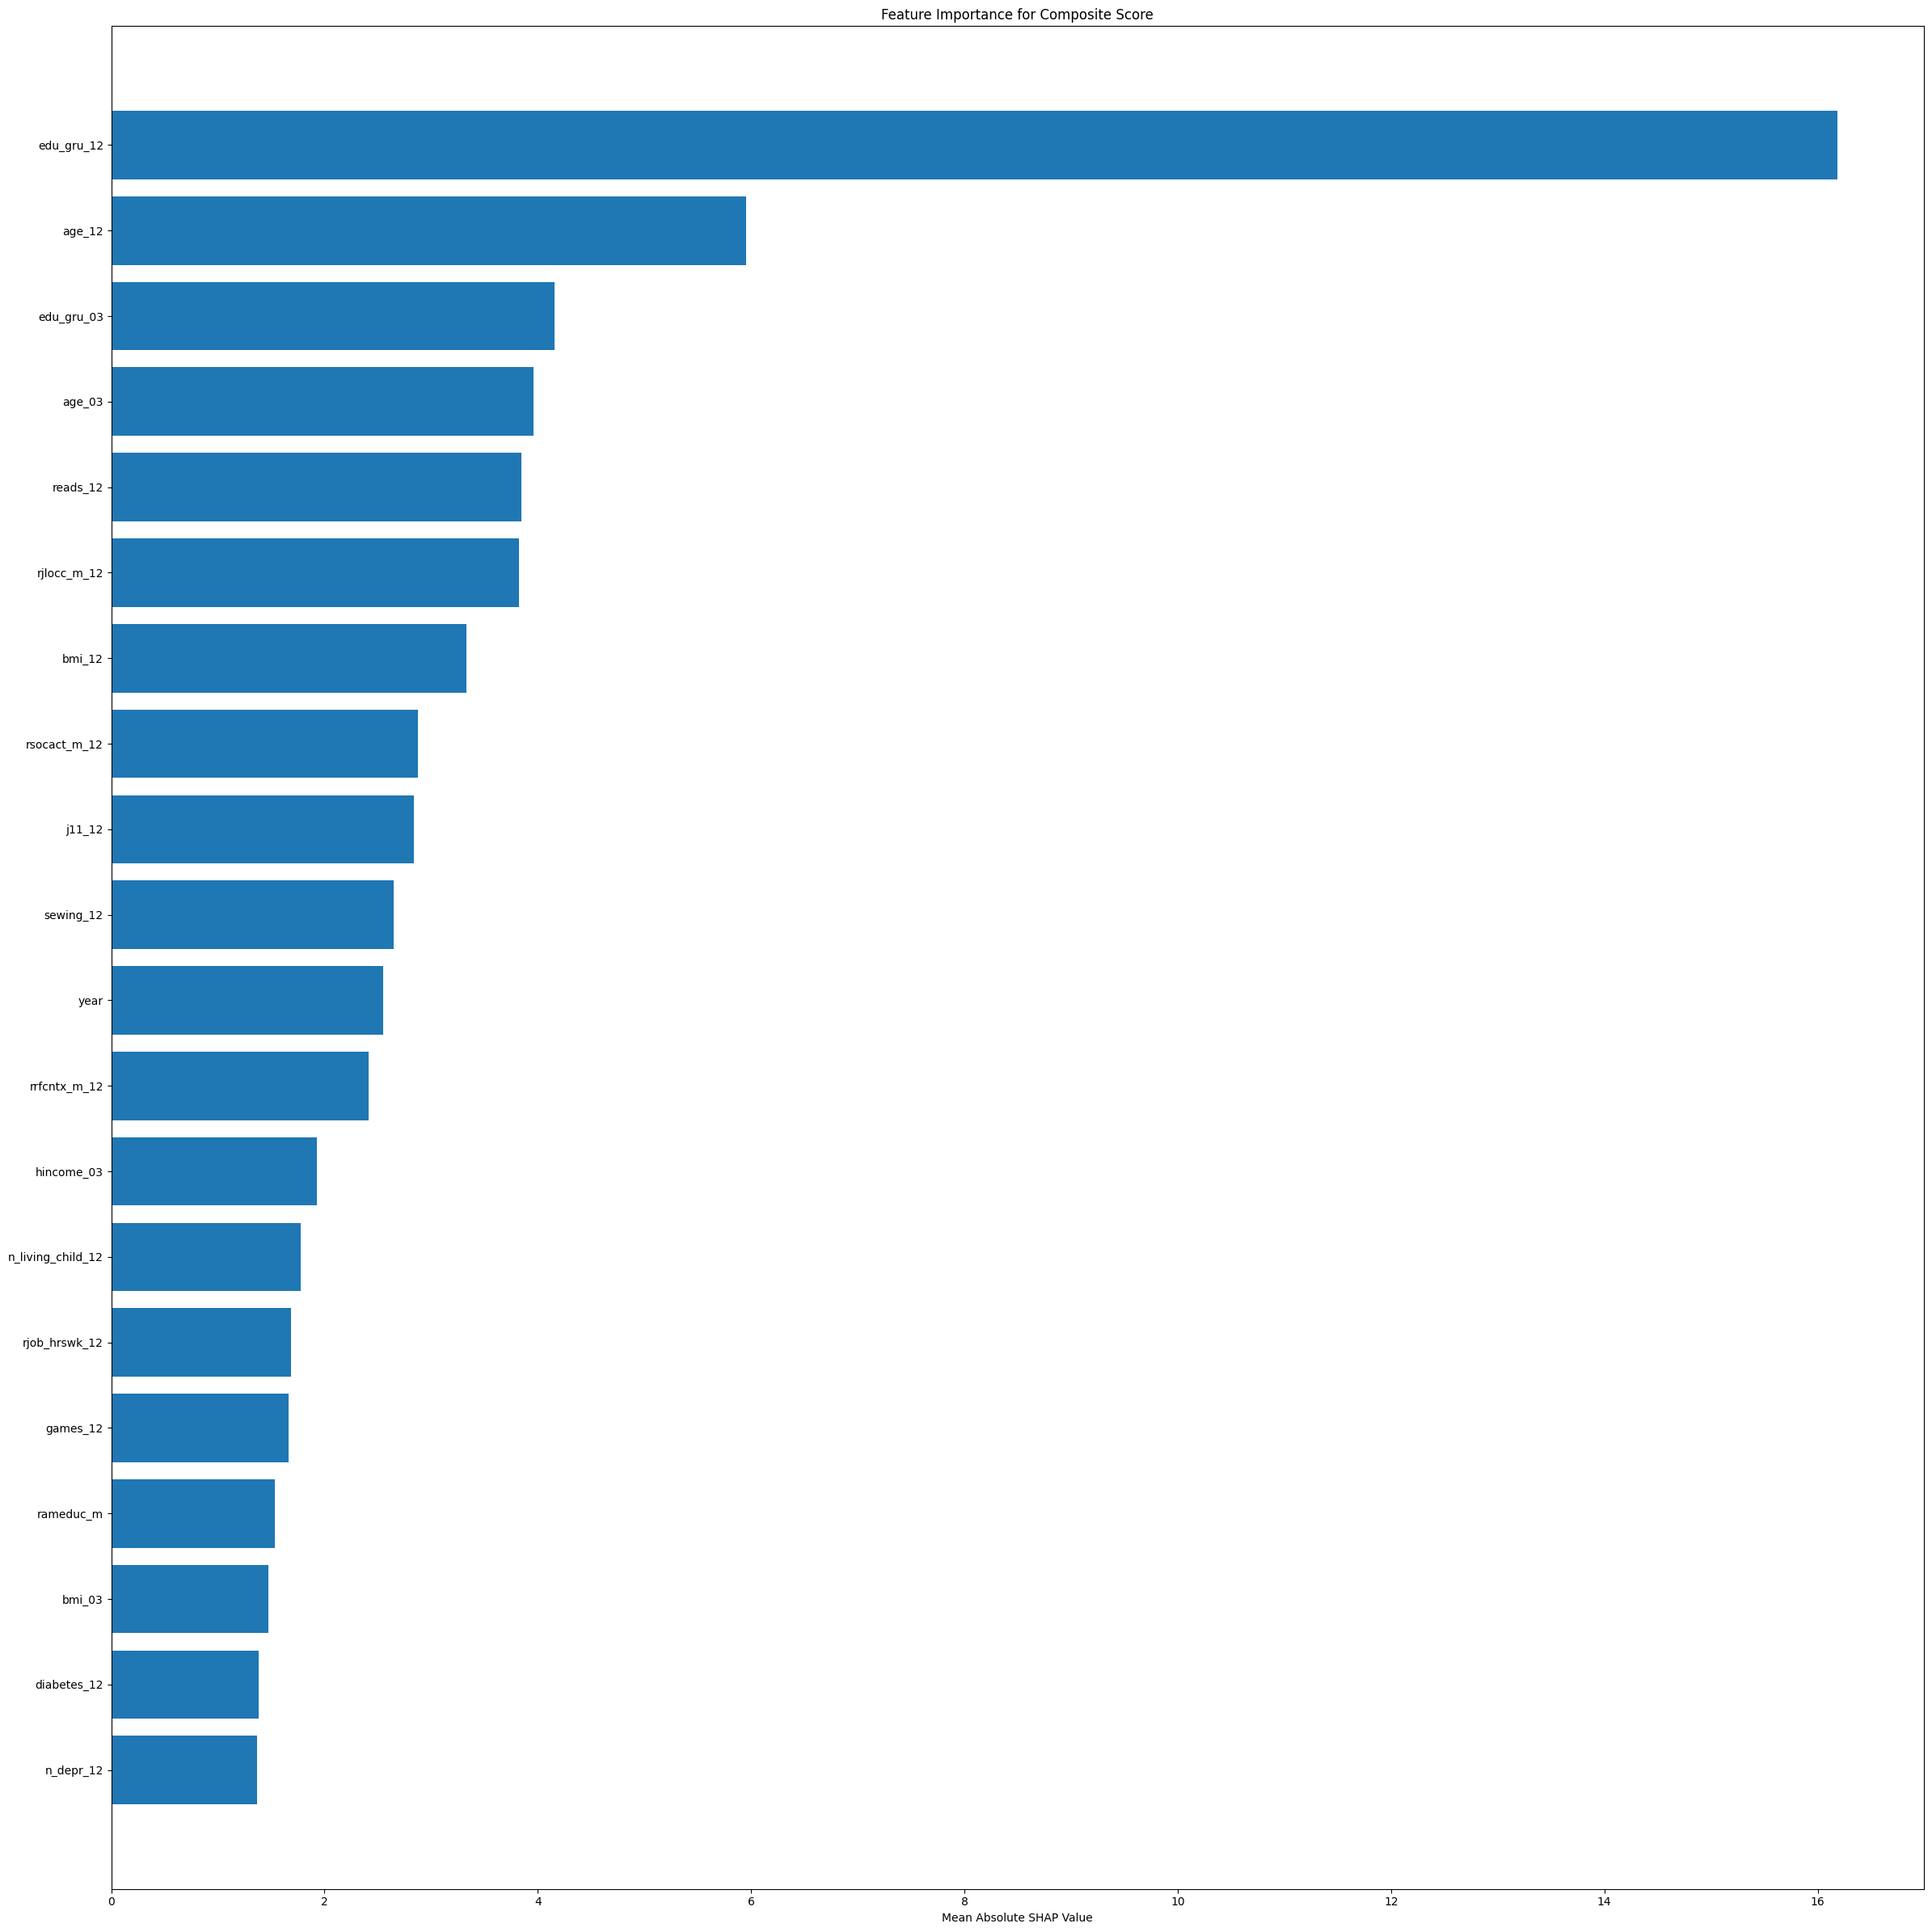

the top 20 features are:  ['edu_gru_12', 'age_12', 'edu_gru_03', 'age_03', 'reads_12', 'rjlocc_m_12', 'bmi_12', 'rsocact_m_12', 'j11_12', 'sewing_12', 'year', 'rrfcntx_m_12', 'hincome_03', 'n_living_child_12', 'rjob_hrswk_12', 'games_12', 'rameduc_m', 'bmi_03', 'diabetes_12', 'n_depr_12']
the rank of rjob_hrswk_change is: 108 out of 195 features
the rank of max_work_year is: 68 out of 195 features
the rank of years_since_work is: 71 out of 195 features
the rank of hincome_change is: 55 out of 195 features
the rank of niadl_change is: 86 out of 195 features
the rank of adl_change is: 120 out of 195 features
the rank of depr_change is: 73 out of 195 features
the rank of glob_hlth_change is: 92 out of 195 features
the rank of bmi_change is: 23 out of 195 features
the rank of edu_gru_change is: 181 out of 195 features
the rank of illnesses_change is: 133 out of 195 features


In [11]:
# Make predictions
y_pred = model2.predict(test_df)

# Calculate metrics
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Plot predictions vs actual
def plot_predictions_vs_actual(y_test, y_pred):
    plt.figure(figsize=(18, 18))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs Actual Values")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.tight_layout()
    # plt.savefig('/home/data3/Ali/Code/Moghis/results/XGBoost/predictions_vs_actual_composite_score.png', bbox_inches='tight')
    plt.show()

plot_predictions_vs_actual(y_test, y_pred)

explainer = shap.TreeExplainer(model2)
shap_values_xgb = explainer.shap_values(test_df)
feature_importance = pd.DataFrame({
    'Feature': main_df.columns.to_list(),
    'Mean_Absolute_SHAP': np.mean(np.abs(shap_values_xgb), axis=0)
})

feature_importance = feature_importance.sort_values(by='Mean_Absolute_SHAP', ascending=False).reset_index(drop=True)

# feature_importance.to_csv('/home/data3/Ali/Code/Moghis/results/XGBoost/feature_importance_composite_score.csv', index=False)
plt.figure(figsize=(24, 24))
plt.barh(feature_importance['Feature'][:20], feature_importance['Mean_Absolute_SHAP'][:20])
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance for Composite Score')
plt.tight_layout()
plt.show()
# plt.savefig('/home/data3/Ali/Code/Moghis/results/XGBoost/feature_importance_plot_composite_score.png', bbox_inches='tight')
plt.close()

print("the top 20 features are: ", feature_importance['Feature'][:20].to_list())

created_features = ["rjob_hrswk_change", "max_work_year", "years_since_work", "hincome_change", "niadl_change", "adl_change", "depr_change", "glob_hlth_change", "bmi_change", "edu_gru_change", "illnesses_change"]
for feature in created_features:
    print(f"the rank of {feature} is: {feature_importance[feature_importance['Feature'] == feature].index[0]} out of {len(feature_importance)} features")

## Random Forest ##

In [12]:
# Step 1: Handle NaN values
# Replace NaN in numerical columns with the mean
num_imputer = SimpleImputer(strategy='mean')
main_df[main_df.select_dtypes(include=['number']).columns] = num_imputer.fit_transform(
    main_df.select_dtypes(include=['number'])
)
test_df[test_df.select_dtypes(include=['number']).columns] = num_imputer.transform(
    test_df.select_dtypes(include=['number'])
)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(main_df, y, test_size=0.001, random_state=42)

# Step 2: Apply Target Encoding
# Initialize TargetEncoder
target_encoder = TargetEncoder()

# Fit the encoder on the training data only
categorical_cols = main_df.select_dtypes(include=['object', 'category']).columns

X_train[categorical_cols] = target_encoder.fit_transform(X_train[categorical_cols], y_train)
X_val[categorical_cols] = target_encoder.transform(X_val[categorical_cols])
test_df[categorical_cols] = target_encoder.transform(test_df[categorical_cols])

# Best parameters for CatBoost
best_params = {
  'max_depth': 30,
  'min_samples_split': 22,
  'min_samples_leaf': 6,
  'max_features': 0.8191960808589205,
  'n_estimators': 97
}

model2 = RandomForestRegressor(**best_params, random_state=42)
model2.fit(X_train, y_train)

/tmp/ipykernel_1768454/2082924176.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df[main_df.select_dtypes(include=['number']).columns] = num_imputer.fit_transform(
/tmp/ipykernel_1768454/2082924176.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[test_df.select_dtypes(include=['number']).columns] = num_imputer.transform(
/home/defuser/miniconda3/envs/moghis/lib/python3.9/site-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 

AttributeError: 'super' object has no attribute '__sklearn_tags__'


Mean Squared Error: 29.0562
R^2 Score: -0.7593


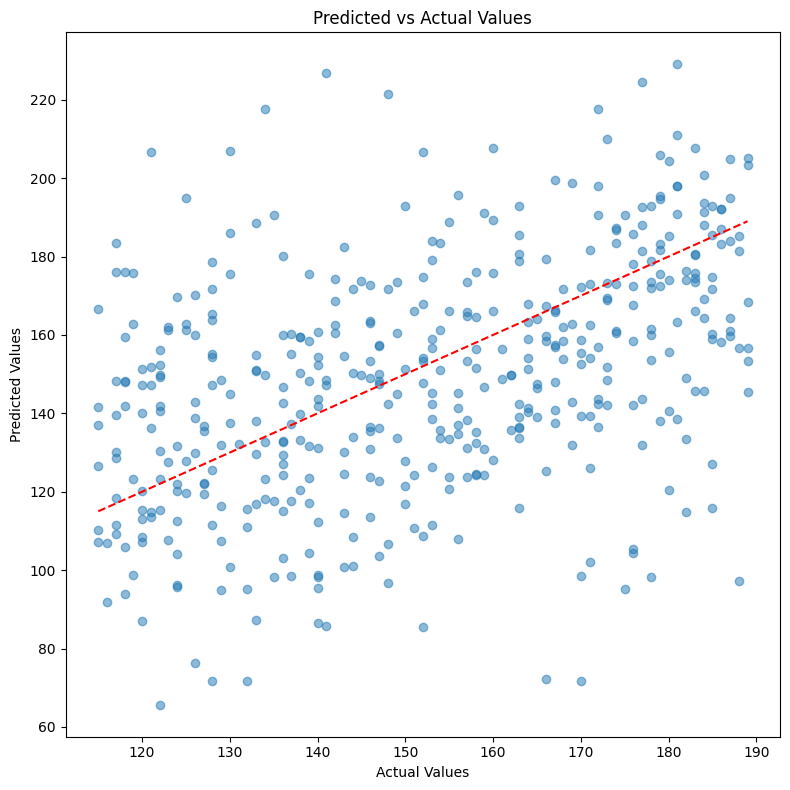

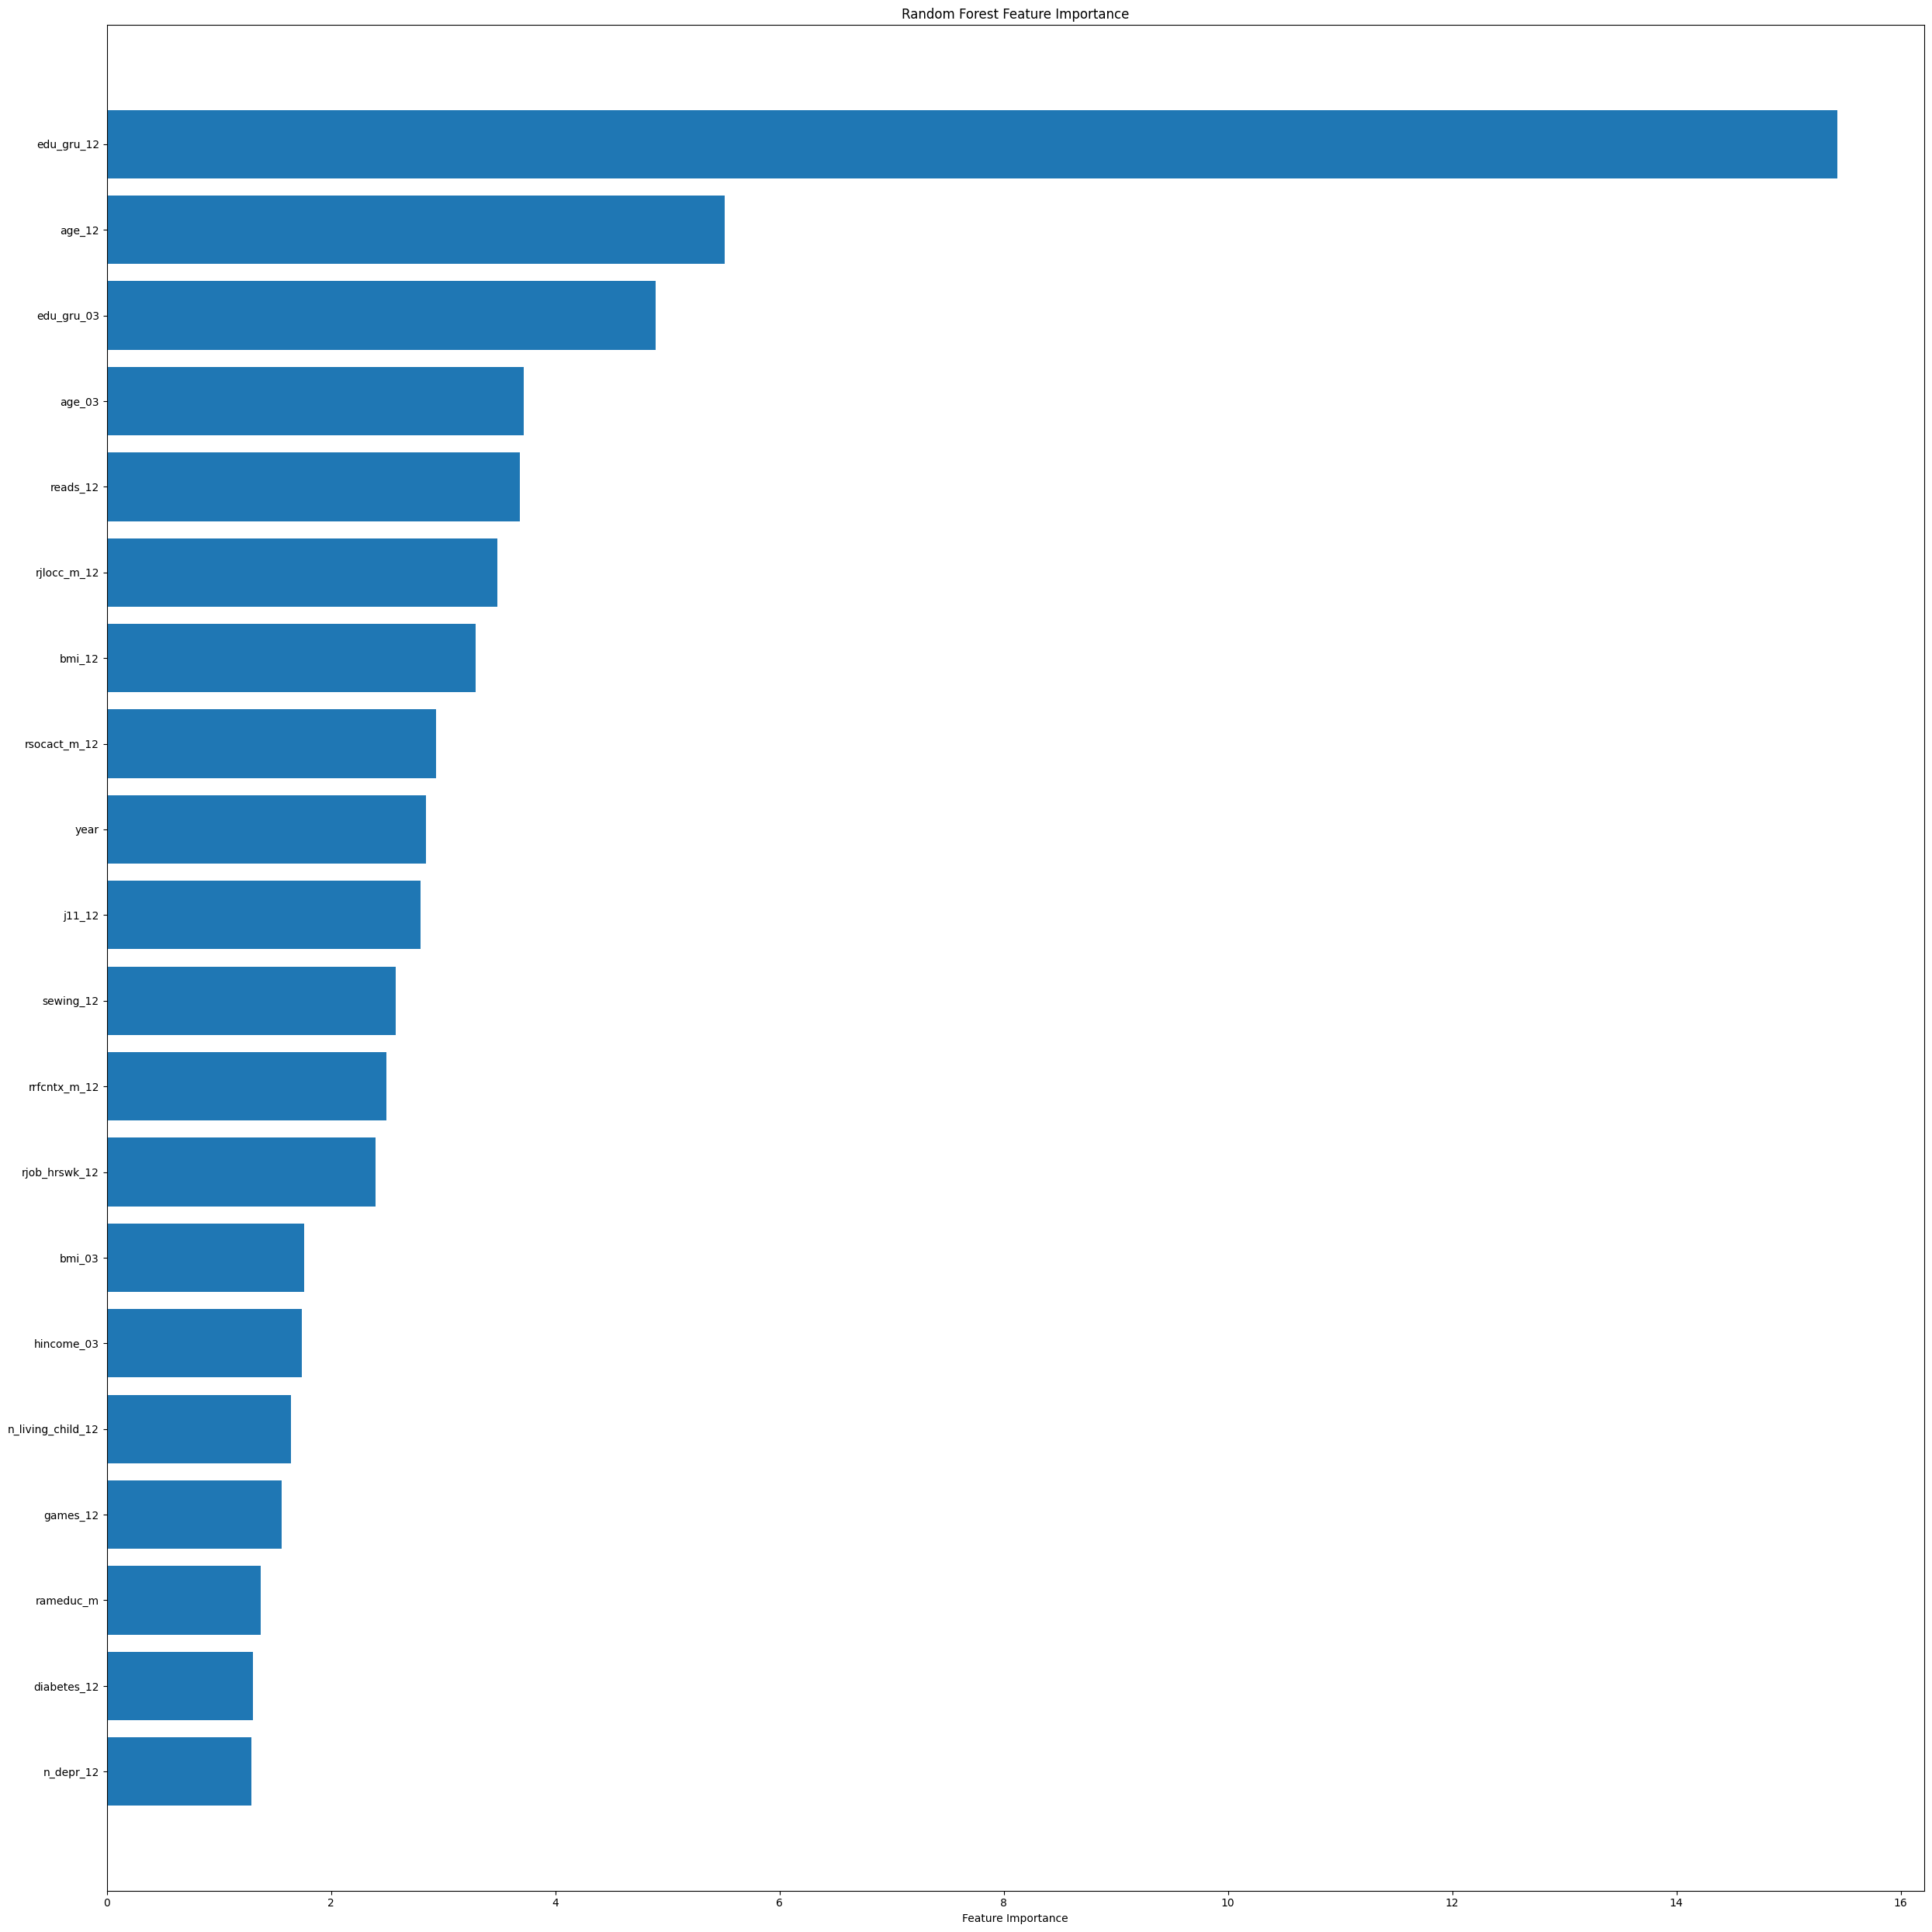

the top 20 features are:  ['edu_gru_12', 'age_12', 'edu_gru_03', 'age_03', 'reads_12', 'rjlocc_m_12', 'bmi_12', 'rsocact_m_12', 'year', 'j11_12', 'sewing_12', 'rrfcntx_m_12', 'rjob_hrswk_12', 'bmi_03', 'hincome_03', 'n_living_child_12', 'games_12', 'rameduc_m', 'diabetes_12', 'n_depr_12']
the rank of hincome_change is: 57 out of 195 features
the rank of niadl_change is: 81 out of 195 features
the rank of adl_change is: 139 out of 195 features
the rank of depr_change is: 69 out of 195 features
the rank of glob_hlth_change is: 99 out of 195 features
the rank of edu_gru_change is: 179 out of 195 features
the rank of illnesses_change is: 138 out of 195 features


In [13]:
# Make predictions
y_pred = model2.predict(test_df)

# Calculate metrics
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Plot predictions vs actual
def plot_predictions_vs_actual(y_test, y_pred):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs Actual Values")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.tight_layout()
    # plt.savefig('/home/data3/Ali/Code/Moghis/results/RandomForest/predictions_vs_actual_composite_score.png', bbox_inches='tight')
    plt.show()

plot_predictions_vs_actual(y_test, y_pred)

# Extract feature importances
explainer = shap.TreeExplainer(model2)
shap_values_rf = explainer.shap_values(test_df)
rf_feature_importance = pd.DataFrame({
    'Feature': main_df.columns.to_list(),
    'Importance': np.mean(np.abs(shap_values_rf), axis=0)
})

# Sort by importance
rf_feature_importance = rf_feature_importance.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Save to CSV
# rf_feature_importance.to_csv('/home/data3/Ali/Code/Moghis/results/RandomForest/feature_importance_rf.csv', index=False)

# Plot feature importance
plt.figure(figsize=(25, 25))
plt.barh(rf_feature_importance['Feature'][:20], rf_feature_importance['Importance'][:20])
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()
# plt.savefig('/home/data3/Ali/Code/Moghis/results/RandomForest/feature_importance_plot_rf.png', bbox_inches='tight')
plt.close()
# 'rjob_hrswk_change', "max_work_year", "years_since_work", "bmi_change"

print("the top 20 features are: ", rf_feature_importance['Feature'][:20].to_list())

created_features = ["hincome_change", "niadl_change", "adl_change", "depr_change", "glob_hlth_change", "edu_gru_change", "illnesses_change"]
for feature in created_features:
    if len(rf_feature_importance[rf_feature_importance['Feature'] == feature]) == 0:
        print({feature})
    print(f"the rank of {feature} is: {rf_feature_importance[rf_feature_importance['Feature'] == feature].index[0]} out of {len(rf_feature_importance)} features")

# Combined values

In [14]:
weights = {
    "lgb": 0.25985829,
    "catboost": 0.38508924,
    "xgb": 0.21887303,
    "rf": 0.13617944
}

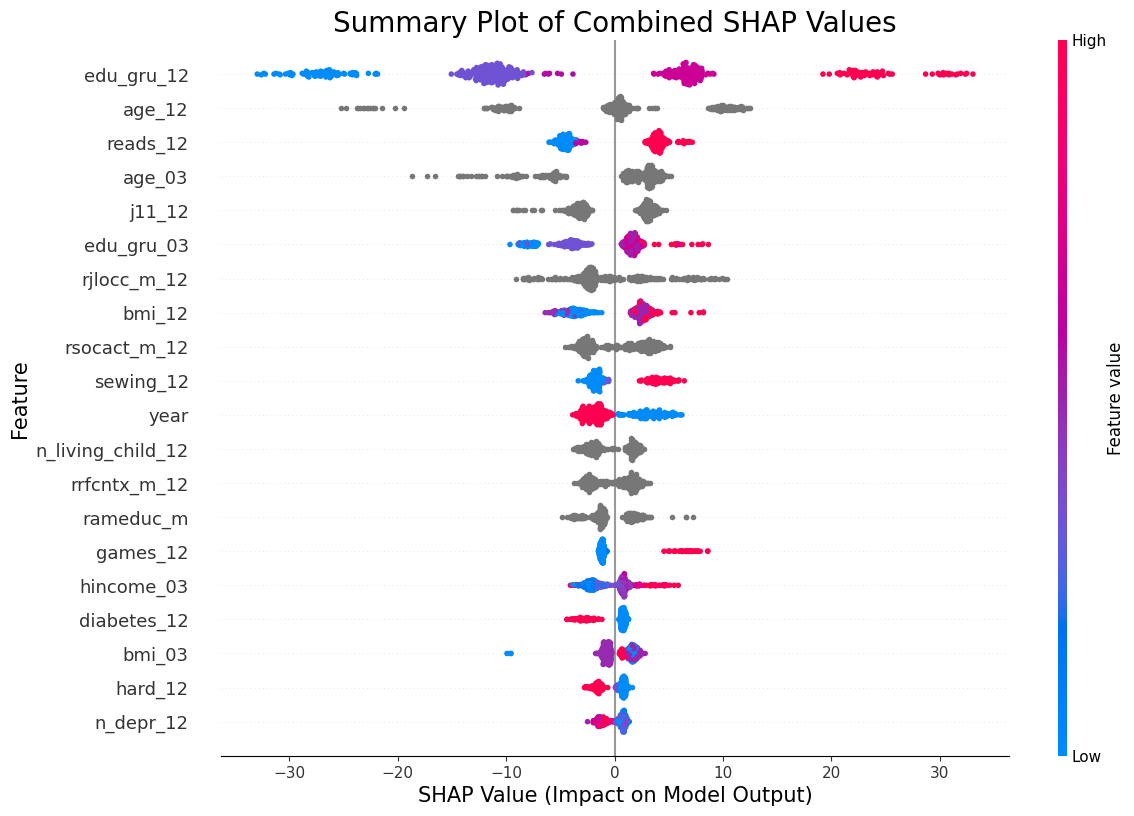

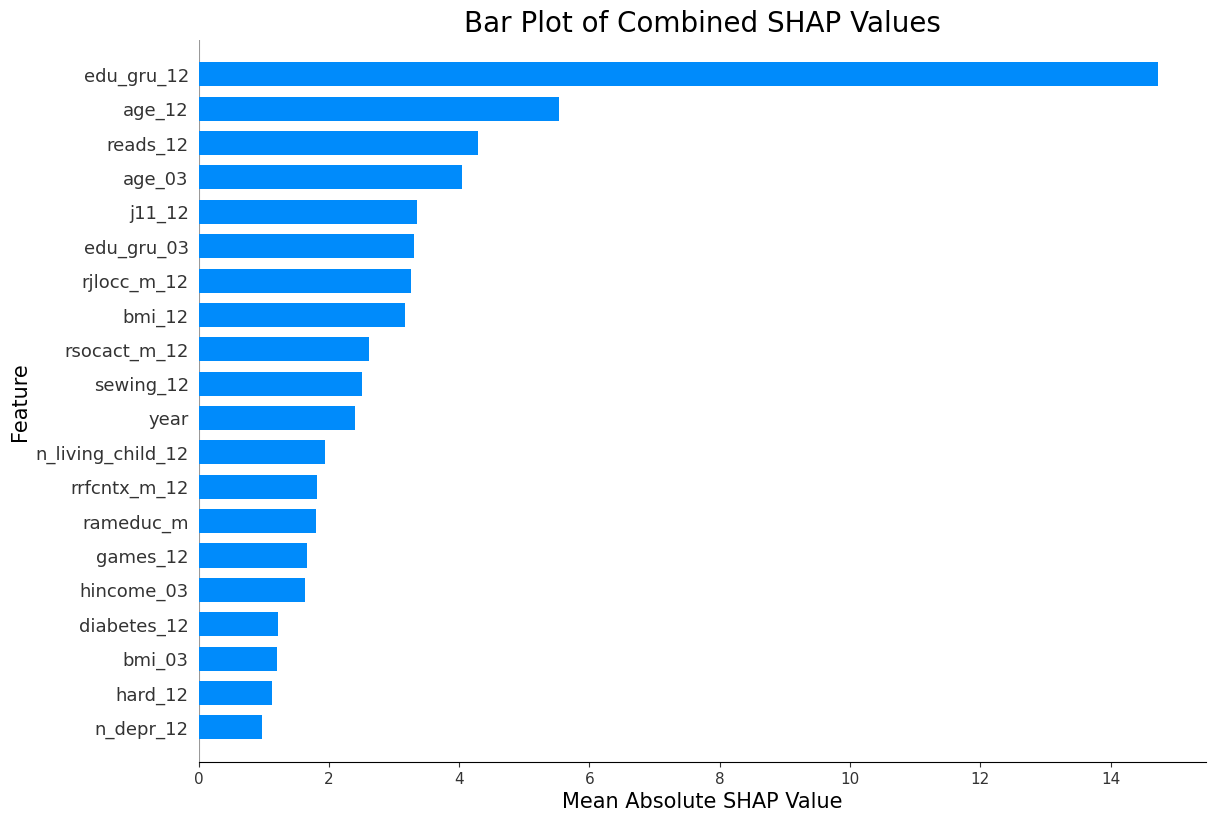

In [15]:
# Combine SHAP values using the weights
combined_shap_values = (
    weights["lgb"] * shap_values_lgb +
    weights["catboost"] * shap_values_catboost +
    weights["xgb"] * shap_values_xgb +
    weights["rf"] * shap_values_rf
)

# Visualize combined SHAP values (e.g., summary plot)
shap.summary_plot(combined_shap_values, test_df, plot_size=(12, 8), show=False)
plt.title("Summary Plot of Combined SHAP Values", fontsize=20)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=15)
plt.ylabel("Feature", fontsize=15)
plt.show()

shap.summary_plot(combined_shap_values, test_df, plot_type="bar", plot_size=(12, 8), show=False)
plt.title("Bar Plot of Combined SHAP Values", fontsize=20)
plt.xlabel("Mean Absolute SHAP Value", fontsize=15)
plt.ylabel("Feature", fontsize=15)
plt.show()